In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import pandas as pd


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset_full = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset_full = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_data, val_data = random_split(trainset_full, [50000, 10000])

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.70MB/s]


In [4]:
EPOCHS = 10
LEARNING_RATE = 0.01
BATCH_SIZE = 64

In [5]:
class VerticalMNIST(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        client0_features = image[:, :, :14]
        client1_features = image[:, :, 14:]
        return client0_features, client1_features, label

vfl_train_dataset = VerticalMNIST(train_data)
vfl_val_dataset = VerticalMNIST(val_data)
vfl_test_dataset = VerticalMNIST(testset_full)

vfl_train_loader = DataLoader(vfl_train_dataset, batch_size = BATCH_SIZE, shuffle = True)
vfl_val_loader = DataLoader(vfl_val_dataset, batch_size = BATCH_SIZE, shuffle = False)
vfl_test_loader = DataLoader(vfl_test_dataset, batch_size = BATCH_SIZE, shuffle = False)


In [6]:
class PartialModel(nn.Module):
    def __init__(self):
        super(PartialModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size = 3, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 14 * 7, 64)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(-1, 16 * 14 * 7)
        x = torch.relu(self.fc1(x))
        return x


class TopModel(nn.Module):
    def __init__(self):
        super(TopModel, self).__init__()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        return self.fc2(x)


In [7]:
def plot_confusion_matrix(cm, classes, title = 'Confusion Matrix'):
    cm_df = pd.DataFrame(cm, index = classes, columns = classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot = True, cmap = "Blues", fmt = 'g')
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def evaluate_vfl(client0_model, client1_model, top_model, data_loader, class_names, plot_cm = False, title_prefix = ""):
    client0_model.eval()
    client1_model.eval()
    top_model.eval()
    true_labels, pred_labels = [], []

    with torch.no_grad():
        for c0_features, c1_features, targets in data_loader:
            c0_features, c1_features = c0_features.to(device), c1_features.to(device)
            c0_output = client0_model(c0_features)
            c1_output = client1_model(c1_features)
            combined_output = torch.cat((c0_output, c1_output), dim = 1)
            final_outputs = top_model(combined_output)
            _, predicted = torch.max(final_outputs.data, 1)
            true_labels.extend(targets.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average = 'weighted', zero_division = 0)
    recall = recall_score(true_labels, pred_labels, average = 'weighted', zero_division = 0)
    f1 = f1_score(true_labels, pred_labels, average = 'weighted', zero_division = 0)

    if plot_cm:
        cm = confusion_matrix(true_labels, pred_labels)
        plot_confusion_matrix(cm, class_names, title = f'{title_prefix} Confusion Matrix')

    return accuracy, precision, recall, f1


def train_vfl(client0_model, client1_model, top_model, train_loader, val_loader, epochs, learning_rate):
    params = list(client0_model.parameters()) + list(client1_model.parameters()) + list(top_model.parameters())
    optimizer = optim.SGD(params, lr = learning_rate)
    criterion = nn.CrossEntropyLoss()
    val_accuracy_history = []

    for epoch in range(epochs):
        client0_model.train()
        client1_model.train()
        top_model.train()
        running_loss = 0.0

        for c0_features, c1_features, targets in train_loader:
            c0_features, c1_features, targets = c0_features.to(device), c1_features.to(device), targets.to(device)
            optimizer.zero_grad()

            c0_output = client0_model(c0_features)
            c1_output = client1_model(c1_features)

            combined_output = torch.cat((c0_output, c1_output), dim=1)
            final_outputs = top_model(combined_output)

            loss = criterion(final_outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        val_acc, _, _, _ = evaluate_vfl(client0_model, client1_model, top_model, val_loader, [str(i) for i in range(10)])
        val_accuracy_history.append(val_acc)
        print(f"Epoch {epoch+1}/{epochs} - Training Loss: {running_loss/len(train_loader):.4f} | Validation Accuracy: {val_acc * 100:.2f}%")

    return val_accuracy_history

--- Starting Vertical Federated Learning (VFL) Training ---
Epoch 1/10 - Training Loss: 1.0086 | Validation Accuracy: 84.13%
Epoch 2/10 - Training Loss: 0.3559 | Validation Accuracy: 89.84%
Epoch 3/10 - Training Loss: 0.2752 | Validation Accuracy: 90.94%
Epoch 4/10 - Training Loss: 0.2310 | Validation Accuracy: 93.40%
Epoch 5/10 - Training Loss: 0.1988 | Validation Accuracy: 93.93%
Epoch 6/10 - Training Loss: 0.1735 | Validation Accuracy: 94.92%
Epoch 7/10 - Training Loss: 0.1537 | Validation Accuracy: 94.95%
Epoch 8/10 - Training Loss: 0.1367 | Validation Accuracy: 95.97%
Epoch 9/10 - Training Loss: 0.1246 | Validation Accuracy: 96.30%
Epoch 10/10 - Training Loss: 0.1133 | Validation Accuracy: 96.31%
--- VFL Training Finished ---


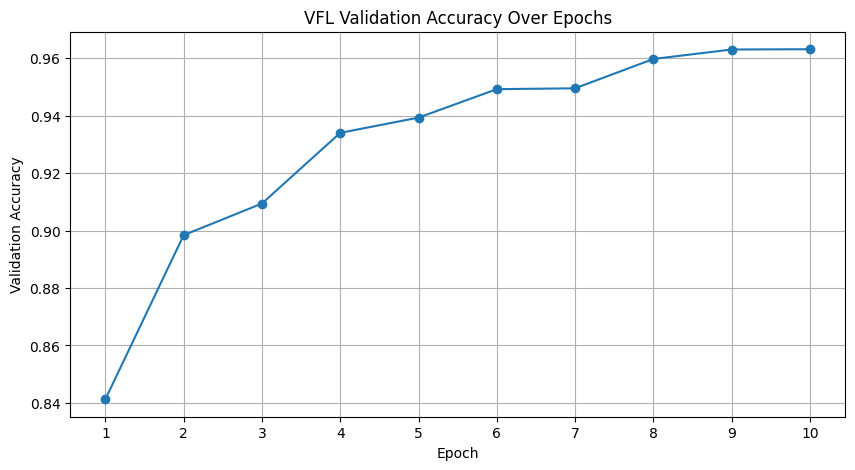


--- Evaluating Final VFL Model on Test Set ---


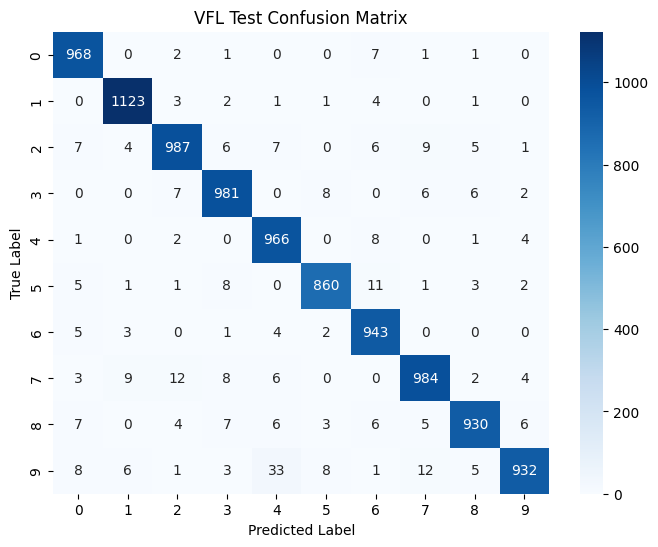

Final Test Accuracy: 96.74%
Final Test Precision: 0.9676
Final Test Recall: 0.9674
Final Test F1-Score: 0.9673


In [10]:
client0_model = PartialModel().to(device)
client1_model = PartialModel().to(device)
top_model = TopModel().to(device)
class_names = [str(i) for i in range(10)]

print("--- Starting Vertical Federated Learning (VFL) Training ---")
val_acc_history = train_vfl(
    client0_model, client1_model, top_model,
    vfl_train_loader, vfl_val_loader,
    epochs=EPOCHS, learning_rate=LEARNING_RATE
)
print("--- VFL Training Finished ---")

plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), val_acc_history, marker='o')
plt.title("VFL Validation Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.xticks(range(1, EPOCHS + 1))
plt.grid(True)
plt.show()

print("\n--- Evaluating Final VFL Model on Test Set ---")
test_acc, test_prec, test_rec, test_f1 = evaluate_vfl(
    client0_model, client1_model, top_model,
    vfl_test_loader, class_names,
    plot_cm=True, title_prefix="VFL Test"
)

print(f"Final Test Accuracy: {test_acc * 100:.2f}%")
print(f"Final Test Precision: {test_prec:.4f}")
print(f"Final Test Recall: {test_rec:.4f}")
print(f"Final Test F1-Score: {test_f1:.4f}")